# Assignment #3: Random Forest + Boosting (Binary Classification)
### Luke Schwenke
### April 22, 2023


In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
adult_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
                       header = None, skipinitialspace=True)

In [3]:
list_of_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation",
                   "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", 
                   "native-country", "salary"]

adult_df.columns = list_of_columns

In [4]:
adult_df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [5]:
adult_df.shape

(32561, 15)

In [6]:
# Remove fnlwgt column
adult_df = adult_df.drop(adult_df.columns[2], axis=1)

In [7]:
binary_map = {'<=50K': 0, '>50K': 1}

# replace the string values with binary values
adult_df.replace(binary_map, inplace=True)

In [8]:
# Create X and y dataframes
X = adult_df.drop('salary', axis=1)
y = adult_df['salary']

In [9]:
# Dummy encode categorical columns
X_encoded = pd.get_dummies(X)

In [10]:
X_encoded.shape

(32561, 107)

In [11]:
# Split into X/y Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=777)

In [12]:
# Verify both datasets have the same number of columns (107)
X_train.shape[1] == X_test.shape[1]

True

# Random Forest Classifer - Base Model

In [13]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [14]:
# Predict the Probabilities and Classes
y_pred_prob = rf.predict_proba(X_test)
y_pred_class = rf.predict(X_test)

In [15]:
# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred_class))

Confusion Matrix:
 [[6805  617]
 [ 878 1469]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      7422
           1       0.70      0.63      0.66      2347

    accuracy                           0.85      9769
   macro avg       0.79      0.77      0.78      9769
weighted avg       0.84      0.85      0.84      9769



In [16]:
# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_class)
print(auc_score)

0.7713870898445954


In [17]:
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Print the top 5 features
print("Top 5 Features:")
for i in range(5):
    print(f"{i+1}. {names[i]} ({importances[indices[i]]:.4f})")

Top 5 Features:
1. age (0.2264)
2. hours-per-week (0.1150)
3. capital-gain (0.1004)
4. marital-status_Married-civ-spouse (0.0706)
5. education-num (0.0674)


In [18]:
# Make predictions on Train dataset
y_pred_class_train = rf.predict(X_train)

# Print the classification report
print("Classification Report:\n", classification_report(y_train, y_pred_class_train))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     17298
           1       0.97      0.95      0.96      5494

    accuracy                           0.98     22792
   macro avg       0.98      0.97      0.97     22792
weighted avg       0.98      0.98      0.98     22792



There is evidence that the model is overfitting because the predictions on the Train dataset returns an accuracy of 98% whereas the Test predictions return an accuracy of 85%. This tells us **the model overfit a bit on the Training set and cannot generalize as well to unseen data.**

# AdaBoost Classifier - GridSearch

In [19]:
# Default AdaBoost
ada = AdaBoostClassifier()

# Define the parameter grid to search over
param_grid = {'n_estimators': [100, 200, 300, 400],
              'learning_rate': [0.2, 0.4, 0.6, 0.8, 1, 1.2]}

# Define the GridSearchCV object with 5 cross-fold and "roc_auc" scoring
grid_search = GridSearchCV(ada, param_grid, cv=5, scoring='roc_auc')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.2, 0.4, 0.6, 0.8, 1, 1.2],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='roc_auc')

In [20]:
# Print the best parameters and their corresponding score
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best score: {:.2f}'.format(grid_search.best_score_))

# Make predictions on the testing data using the best estimator found by GridSearchCV
y_pred_class = grid_search.best_estimator_.predict(X_test)
y_pred_probs = grid_search.best_estimator_.predict_proba(X_test)

Best parameters: {'learning_rate': 1.2, 'n_estimators': 400}
Best score: 0.92


In [21]:
# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred_class))

Confusion Matrix:
 [[6996  426]
 [ 832 1515]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      7422
           1       0.78      0.65      0.71      2347

    accuracy                           0.87      9769
   macro avg       0.84      0.79      0.81      9769
weighted avg       0.87      0.87      0.87      9769



In [22]:
# Calculate the ROC AUC score of the classifier
roc_auc = roc_auc_score(y_test, y_pred_class)
print('ROC AUC: {:.2f}'.format(roc_auc))

ROC AUC: 0.79


In [23]:
importances = grid_search.best_estimator_.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Print the top 5 features
print("Top 5 Features:")
for i in range(5):
    print(f"{i+1}. {names[i]} ({importances[indices[i]]:.4f})")

Top 5 Features:
1. capital-gain (0.3625)
2. capital-loss (0.2775)
3. age (0.1050)
4. hours-per-week (0.0525)
5. education-num (0.0125)


In [24]:
# Make predictions on Train dataset
y_pred_class_train = grid_search.best_estimator_.predict(X_train)

# Print the classification report
print("Classification Report:\n", classification_report(y_train, y_pred_class_train))

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92     17298
           1       0.78      0.64      0.70      5494

    accuracy                           0.87     22792
   macro avg       0.84      0.79      0.81     22792
weighted avg       0.87      0.87      0.87     22792



Unlike the base RF classifier, **the AdaBoost classifier does not show signs of being overfit**. This is because values like accuracy are stable at 87% between the Train and Test set.

# Gradient Boosting Classifier - GridSearch

In [25]:
# Default AdaBoost
gb = GradientBoostingClassifier()

# Define the parameter grid to search over
param_grid = {'n_estimators': [100, 200, 300, 400, 500],
              'learning_rate': [0.05, 0.1, 0.5, 1.0],
              'max_depth': [1, 2, 3, 4]}

# Define the GridSearchCV object with 5 cross-fold and "roc_auc" scoring
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='roc_auc')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.5, 1.0],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='roc_auc')

In [26]:
# Print the best parameters and their corresponding score
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best score: {:.2f}'.format(grid_search.best_score_))

# Make predictions on the testing data using the best estimator found by GridSearchCV
y_pred_class = grid_search.best_estimator_.predict(X_test)
y_pred_probs = grid_search.best_estimator_.predict_proba(X_test)

Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500}
Best score: 0.93


In [27]:
# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred_class))

Confusion Matrix:
 [[7000  422]
 [ 790 1557]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      7422
           1       0.79      0.66      0.72      2347

    accuracy                           0.88      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.88      0.87      9769



In [28]:
# Calculate the ROC AUC score of the classifier
roc_auc = roc_auc_score(y_test, y_pred_class)
print('ROC AUC: {:.2f}'.format(roc_auc))

ROC AUC: 0.80


In [29]:
importances = grid_search.best_estimator_.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Print the top 5 features
print("Top 5 Features:")
for i in range(5):
    print(f"{i+1}. {names[i]} ({importances[indices[i]]:.4f})")

Top 5 Features:
1. marital-status_Married-civ-spouse (0.3581)
2. capital-gain (0.1902)
3. education-num (0.1878)
4. age (0.0663)
5. capital-loss (0.0595)


In [30]:
# Make predictions on Train dataset
y_pred_class_train = grid_search.best_estimator_.predict(X_train)

# Print the classification report
print("Classification Report:\n", classification_report(y_train, y_pred_class_train))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93     17298
           1       0.81      0.69      0.74      5494

    accuracy                           0.89     22792
   macro avg       0.86      0.82      0.84     22792
weighted avg       0.88      0.89      0.88     22792



**The GB model does not show signs of being overfit**. This is because there is consistency between the Train and Test set values in the respective classification reports.

# XGBoost - RandomizedSearchCV

In [31]:
xgb = xgb.XGBClassifier()

# Define the parameter grid to search over
param_grid = {'n_estimators': list(range(100,1050,50)),
              'learning_rate': list(np.arange(0.1,1.7,0.1)),
              'max_depth': [1,2],
              'gamma': list(np.arange(0,5.25,0.25))}

# Define the GridSearchCV object with 5 cross-fold and "roc_auc" scoring
random_search = RandomizedSearchCV(xgb, param_grid, cv=5, scoring='roc_auc')

# Fit the GridSearchCV object to the training data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                                  2.5, 2.75, 3.0, 3.25, 3.5,
                  

In [32]:
# Print the best parameters and their corresponding score
print('Best parameters: {}'.format(random_search.best_params_))
print('Best score: {:.2f}'.format(random_search.best_score_))

# Make predictions on the testing data using the best estimator found by GridSearchCV
y_pred_class = random_search.best_estimator_.predict(X_test)
y_pred_probs = random_search.best_estimator_.predict_proba(X_test)

Best parameters: {'n_estimators': 550, 'max_depth': 2, 'learning_rate': 0.4, 'gamma': 0.25}
Best score: 0.93


In [33]:
# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred_class))

Confusion Matrix:
 [[7017  405]
 [ 811 1536]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92      7422
           1       0.79      0.65      0.72      2347

    accuracy                           0.88      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.88      0.87      9769



In [34]:
# Calculate the ROC AUC score of the classifier
roc_auc = roc_auc_score(y_test, y_pred_class)
print('ROC AUC: {:.2f}'.format(roc_auc))

ROC AUC: 0.80


In [35]:
importances = random_search.best_estimator_.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Print the top 5 features
print("Top 5 Features:")
for i in range(5):
    print(f"{i+1}. {names[i]} ({importances[indices[i]]:.4f})")

Top 5 Features:
1. marital-status_Married-civ-spouse (0.3972)
2. education-num (0.0841)
3. occupation_Exec-managerial (0.0610)
4. occupation_Prof-specialty (0.0301)
5. relationship_Own-child (0.0294)


In [36]:
# Make predictions on Train dataset
y_pred_class_train = random_search.best_estimator_.predict(X_train)

# Print the classification report
print("Classification Report:\n", classification_report(y_train, y_pred_class_train))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92     17298
           1       0.80      0.67      0.73      5494

    accuracy                           0.88     22792
   macro avg       0.85      0.81      0.83     22792
weighted avg       0.88      0.88      0.88     22792



**The XGBoost model with Random Search does not show signs of being overfit**. The model output between Train and Test is stable with an accuracy of 87% vs. 88%.

# Concepts

a) The lecture notes describe the Gini Index which is the default criterion used for splitting in sklearn's version of RandomForestClassifier. How does the Gini Index work? (i.e. How is it used to build a top-performing model?). 

* The Gini Index is a measure that determines the best splits for each node. The Gini index is used to quantify the impurity of a dataset; the lower the Gini index, the more homogenous the dataset is, the higher the more random the data is. In a random forest classifier, this is specifically used during the construction of each individual decision tree in the ensemble. For each candidate feature, the Gini index is calculated for every possible split. The feature and split point with the lowest Gini index are chosen as the best split for the node. The dataset is then divided into two subsets based on this split. This is repeated until a tree is built. Many trees are built based off this criterion which then returns a strong model made of many trees.

b) Describe how Random Forest is different from bagging & why this difference can yield improved results.

* Random Forest is an extension of bagging that adds an extra layer of randomness to the process of combining decision trees into a final output. While RF also builds an ensemble of decision trees using bootstrap samples of the original dataset, RF introduces randomness during the tree construction process. Specifically, at each node of a decision tree, instead of considering all features for a split, Random Forest selects a random subset of features. This leads to improved results as it forces the individual trees in the ensemble to be more diverse and less correlated with each other.

c) Describe the importance of the max_depth parameter in Random Forest. Do not just provide a definition, rather think through how bias-variance tradeoff might be impacted by the max_depth parameter.

* When max_depth is set to a small value, the decision trees become more constrained, as they can only make a limited number of splits. In this case, the model tends to have high bias and low variance. High bias means that the model is overly simplistic and does not capture the underlying patterns in the data, which often results in underfitting. However, because the trees are shallow, they are less likely to overfit the training data and have lower variance. In general, a small max_depth can lead to a more stable model, but it might not perform well on complex datasets. On the other hand, when max_depth is set to a large value or left unconstrained, the decision trees can grow more complex and deeper. This allows them to fit the training data more closely, potentially capturing complex patterns and reducing bias. However, this increased complexity can lead to higher variance, as the trees are more likely to fit noise in the training data and overfit. In this case, the model might perform well on the training data but not generalize well to new, unseen data.

d) What does the alpha parameter represent in AdaBoost? Please refer to chapter 7 of the Hands-On ML book if you are struggling.

* The alpha parameter in AdaBoost represents the weight assigned to each individual base learner in the ensemble. It is determined by the performance of the base learner on the weighted training data, with better-performing learners having higher alpha values and more influence in the final model. 

e) In AdaBoost explain how the final predicted class is determined. Be sure to reference the alpha term in your explanation.

* The final predicted class for a given input is determined by a weighted majority vote of the individual base learners in the ensemble. Each base learner contributes to the final prediction based on its assigned alpha value, which reflects its performance on the weighted training data during the training process.

f) In Gradient Boosting, what is the role of the max_depth parameter? Why is it important to tune on this parameter?

* In GB, the max_depth parameter controls the maximum depth of each decision tree in the ensemble. It determines how deep an individual tree can grow and, consequently, affects the complexity of the model. It is important to tune since a small max_depth will create shallow/smaller trees which may not capture complex patterns and lead to underfitting with high bias. Oppositely, a large max_depth will cause deep trees which can capture many aptters but be overfit with high variance.


g) In Part (e) of Steps 2-5 you determined the top 5 predictors across each model. Do any predictors show up in the top 5 predictors for all three models? If so, comment on if this predictor makes sense given what you are attempting to predict. (Note: If you don't have any predictors showing up across all 3 predictors, explain one that shows up in 2 of them).

* A few predictors consistenly showed as important across the models including: age, capital-gain, and education-num. All 3 of these variables make sense since we are trying to predict higher-income earners. Age is always a strong predictor of wealthy since older people have had more time to gain a higher salary, education levels are directly correlated with job prospects and income, and capital gains in the market are usually tied to people with higher incomes and more money to use.

h) From the models run in steps 2-5, which performs the best based on the Classification Report? Support your reasoning with evidence from your test data and be sure to share the optimal hyperparameters found from your grid search.

* The **best performing model on the test data was a tie between XGBoost and Gradient Boost which both had accuracies of 88% and AUC values of 80%**. The best XGBoost hyperparameters were as follows: 'n_estimators': 550, 'max_depth': 2, 'learning_rate': 0.4, 'gamma': 0.25. The best Gradient Boost hyperparameters were as follows: Best parameters: 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500.

i) For your best performing model, plot out a ROC curve using your test data. Feel free to use sklearn, matplotlib or any other method in python. Describe what the x-axis & y-axis of the ROC curve tell us about a classifier.

* See ROC curve plots below. The ROC curve is a graphical representation of the performance of a binary classifier. It plots the True Positive Rate (TPR) on the y-axis against the False Positive Rate (FPR) on the x-axis for various threshold values of the classifier. A straight line in the middle essentially indicates a coin toss of 50/50. Ideally you want it to curve upwards closer to a value of 100% meaning perfect classification.

In [39]:
# Gradient Boost
y_pred_class = grid_search.best_estimator_.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred_class)

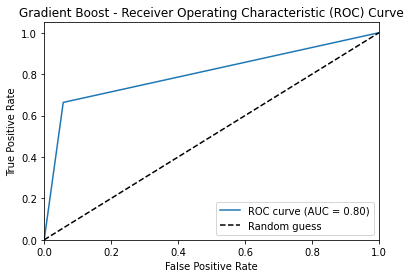

In [40]:
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boost - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [41]:
# XGBoost
y_pred_class = random_search.best_estimator_.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred_class)

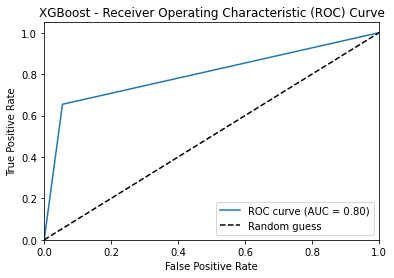

In [43]:
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()